In [1]:
#pip install TextBlob

In [2]:
import sys
import csv
import nltk
import time
import re
import tqdm
import spacy
import string
import numpy as np
import pandas as pd
from collections import Counter


# Gensim
import gensim
import warnings
from gensim import models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
warnings.filterwarnings('ignore')

from textblob import TextBlob
# Import sklearn evaluation metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import machine learning models
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Import sklearn label processing library
from sklearn import preprocessing
# Import sklearn train-test split function
from sklearn.model_selection import train_test_split
# Import feature extraction tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# first step is to import and install if required, the Python packages.


# nltk libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer , wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

# sklearn libraries
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Fine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fine\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read dataset

# We have extracted data having three queries with chatgpt
- Query 1: Tell me in detail about 5 technology topics each statement should have strong sentiments  in bullet form short texts all lines should be comma separated
- Query 2: Tell me more in detail about 5 technology topics you generated above the data should have strong sentiments  about a particular product of each technology pros and cons with strong sentiments in each statement  in bullet form short texts all lines should be comma separated
- Query 3: Tell me more in detail about 5 technology  topics generated above the data should have strong sentiments like end user of that technology review about a particular product of each technology with strong sentiments in each statement  in bullet form short texts all lines should be comma separated, the data should not have repetitive text as generated above, focus should be more on user review
- It generates small amount of data to increase size we have repeated 3rd query two times more
- It generates data about 5 topics Artificial Intelligence, Virtual Reality, IOT, Cloud Computing and Blockchain Technology
- We removed topics from data and save it as text file
- These topics further help us to assign topics to data

In [3]:
with open("chatgpt_text_conversation.txt") as f:
    data = f.readlines()

# Map data to dataframe
- convert data into dataframe

In [4]:
data = pd.DataFrame(data)
data.columns = ['conversation']
data['conversation'] = data['conversation'].str.strip(',"\n')
data.head()

conversation
0  AI's capabilities are astounding, it's transfo...
1  Autonomous cars scare me, I don't trust machin...
2  AI algorithms predicting customer behavior are...
3  Concerned about AI replacing jobs, it could le...
4  AI's ability to analyze big data and derive in...

# Total words in the dataset

In [5]:
# Split each conversation into words
data['words'] = data['conversation'].str.split()

# Count the number of words in each conversation
data['word_count'] = data['words'].apply(len)

# Sum the word counts to get the total number of words in the DataFrame
total_words = data['word_count'].sum()
print('Total words:', total_words)

Total words: 1504


In [6]:
data['conversation'][0]

"AI's capabilities are astounding, it's transforming industries!"

## Check for null values
- There are no duplicates in our data

In [7]:
data.isna().sum()

conversation    0
words           0
word_count      0
dtype: int64

## Drop if there any null values

In [8]:
data.dropna(inplace=True)
data.shape

(124, 3)

# Data Cleaning
- We have removed 
    - all punctuations, 
    - numeric values, 
    - any non-ascii characters, 
    - single characters
    - remove more than one sapce
    - lower case text

In [9]:
def text_clean(text):
    # remove punctuations
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    text = text.translate(translator)
    # remove numeric values
    text = re.sub('[0-9]', ' ', text)
    # remove special characters and single characters
    text = re.sub(r"\b[A-Za-zÀÃ-ž]\b",' ', text)
    # lowercase text and remove extra spaces
    text = re.sub('\s+',' ',text).lower().strip()
    
    return text

# Tokenization
- We have tokenized data using nltk standard tokenizer 
- Remove stop words of english language

In [10]:
def text_tokenize(text):
    # tokenize text and remove stop words
    return " ".join([word for word in text.split() if word not in stop_words])

# Text Cleaning:
To analyze the dataset, we have explored the dataset for null values and any irrelevant data attributes. We do not find any null instances but there are a lot punctuations etc. in the dataset. To increase data interpretability, make it more reliable and decrease computational cost we have removed all punctuation marks, numeric values, remove special characters, and lowercase text to get homogenized data and remove more than one extra space.
# Text Tokenization:
In the next step, we tokenized all text using nltk standard tokenizer and remove stopwords (e.g. the, is etc.) as these words do not provide any specific information.
# Text Lemmatization:
This step is also part of a text processing pipeline that performs lemmatization, a process that converts words to their base or root form, known as "lemmas". This process helps in reducing the dimensionality of the data and consolidating different forms of a word into a single entity for better text analysis. e.g.running --> run


# Lemmatization

In [11]:
# Loading the spacy model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatize_text(text):
    # Create a Doc object by processing the input text with the spacy model
    doc = nlp(text)
    
    # Perform lemmatization on the text and join the lemmas with spaces
    text = [items.lemma_ for items in doc]
    text = " ".join([i for i in text if len(i) >= 3])
    
    # Remove single-character words (excluding numbers and special characters)
    text = re.sub(r"\b[A-Za-zÀÃ-ž]\b",' ', text)
    
    # Remove extra spaces and trim leading/trailing spaces
    text = re.sub('\s+',' ',text).strip()
    
    return text


## Apply data processing functions on data

In [12]:
# apply text clean function on text
data['text'] = data.conversation.apply(text_clean)
# apply text clean function on text
data['text'] = data.text.apply(text_tokenize)
# apply text clean function on text
data['text'] = data.text.apply(lemmatize_text)

## Words frequency Word cloud
- We have plotted wordcloud of tokens in the complete dataset to display frequency of each token
- Font size of text in plot depicts Frequency of each token 

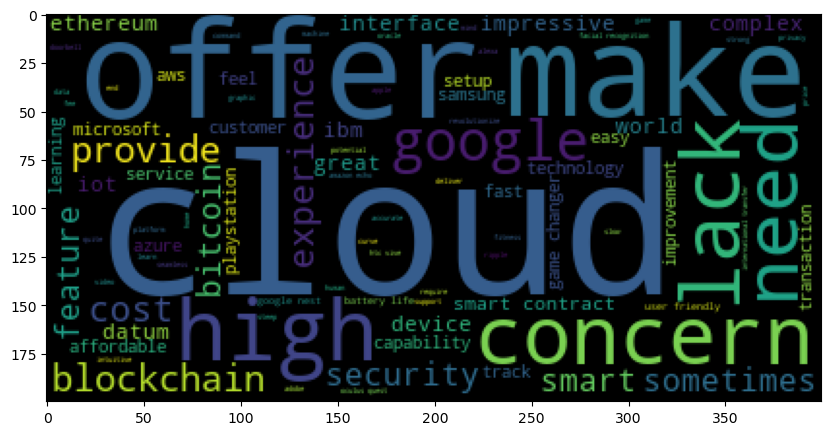

In [13]:
# Import the wordcloud library
from wordcloud import WordCloud
plt.figure(figsize=(10,15))
# Join the different processed titles together.
long_string = ','.join(list(data['text'].values))
# Create a WordCloud object
wordcloud = WordCloud()
# Generate a word cloud
cloud = wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(cloud)

## Text length in complete dataset
- We have find the length of each input instance
- After that find average, minimum and maximum length
- To understand the ratio of text instances in complete data
- Maximum length of text in our dataset is 97
- Minimum length of text in our dataset is 31
- Average number of instance have length around 60

In [14]:
# find the length of word / tokens in each text
data['word_len'] = data['text'].str.len()
# find and display maximum length of text
print("Maximum text length: ", data['word_len'].max())
# find and display minimum length of text
print("Minimum text length: ", data['word_len'].min())
# find and display average length of text
print("Average text length: ", data['word_len'].mean())

Maximum text length:  97
Minimum text length:  31
Average text length:  59.88709677419355


# Topic Modeling
- A particular type of text mining is called topic modelling which extracts recurring patterns from text-based information. It involves applying models to the collection of text data in order to create a representation of the subjects covered there. An NLP method known as topic modelling uses statistical connections of words in text data to construct latent topics. Topic modelling is a method of information extraction and classification of enormous collections of texts. Without using any predetermined dictionaries or interpretive rules, these latent themes are constructed. A set of texts' fundamental subjects are discovered using topic modelling, which also provides quantitative measurements that identify and characterise the topics of specific texts among a set of texts and enable thematic comparisons both inside and between texts. Gensim library has been used to build model. To build LDA on the dataset we have extracted unigrams from the text. We have extracted bow features from the dataset and apply LDA model on extracted features. 
- Unique dictionary we get from our dataset has 536 tokens
- As having conversation with chatgpt we asked about only five topics so we train the topic model with 5 topics
- To check how best our model is to distinguish all these topics
- After training LDA model we have extracted keywords that define each topic
- Analyzing keywords we have identified that model is able to group all topics correctly other than AI topic, even on small dataset
- As dataset is very small so generated probabilities may vary at each iteration
- On small dataset get as much good results as possible we have assigned model 1000 passes
- We have evaluated the LDA model results using Coherence score, Coherence score of LDA model is around 51%.

In [15]:
# Create a dictionary from the list of words
texts = data['text'].str.split(" ")
dictionary = corpora.Dictionary(texts)
# filter tokens below frequency of 3 words
dictionary.filter_extremes(no_below=1, no_above=1)
# Create a Bag of Words (BOW) representation of the corpus
corpus_bow = [dictionary.doc2bow(text) for text in texts]

In [16]:
#  Count the number of unique tokens in the dictionary
len(dictionary)

536

In [17]:
# Print out the first four documents in the bow representation
for doc in corpus_bow[:4]:
    
    print(doc)

[(0, 1), (1, 1), (2, 1), (3, 1)]
[(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]
[(10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]
[(17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]


In [18]:
lda_model = models.LdaMulticore(corpus=corpus_bow,
                                           id2word=dictionary,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=5,
                                           passes=1000,
                                           minimum_probability=0)

# Applies the trained LDA model to the corpus_bow and returns a list of tuples containing 
#topic probabilities for each document in the corpus.
corpus_lda = lda_model[corpus_bow] 

In [19]:
# Creates a CoherenceModel object from the gensim library with the 'c_v' coherence metric.
# Calculates the coherence score for the LDA model using the get_coherence() method of the CoherenceModel object.

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
print("Coherence score of LDA model:", coherence_model_lda.get_coherence())

Coherence score of LDA model: 0.5424430201010535


- We have generated wordcloud of all topics keywords
- To visualize the relevant frequency of all keywords in each topic

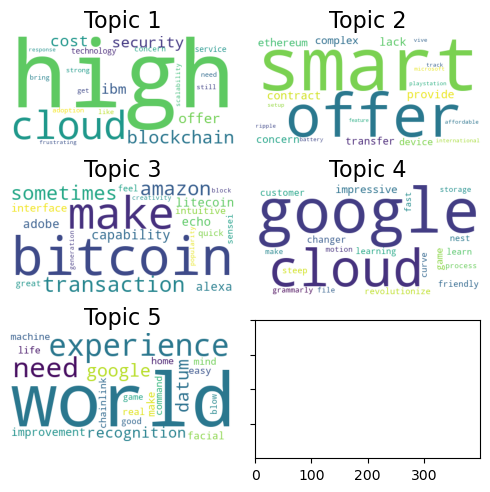

In [20]:
# find number of topics
topics = lda_model.show_topics(formatted=False,num_words = 20)

# for odd number of topics
if len(topics)%2 == 1:
    sub_plts = int(len(topics)/2)
    sub_plts = sub_plts+1
# for even number of topics   
else: 
    sub_plts = int(len(topics)/2)


fig, axes = plt.subplots(sub_plts, 2, figsize=(5,5), sharex=True, sharey=True)

# for odd number of topics
if len(topics)%2 == 1:
    axes_p = axes.flatten()[:-1]
# for even number of topics
else:
    axes_p = axes.flatten()
    
# iterate over topics
for i, ax in enumerate(axes_p):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    # generate wordcloud
    cloud = WordCloud(background_color='white')
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')
    

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
#plt.pad=0
plt.show()

## Keywords in each topic

In [21]:
keywords = {}
topics_list = ['Blockchain', 'Internet of Things', 'Artificial Intelligence', 'Cloud Computing', 'Virtual Reality']
for idx, topic in lda_model.print_topics(-1, num_words=20):
    
    pattern =r'"([A-Za-z0-9_\./\\-]*)"'
    matches = re.findall(pattern, topic)
    keyword = [i for i in matches]
   
    print (topics_list[idx],"::\t ", ", ".join(keyword),"\n")
    keywords[idx+1] = ", ".join(keyword)


Blockchain ::	  high, cloud, blockchain, cost, security, ibm, offer, technology, service, concern, need, adoption, get, bring, like, still, strong, scalability, frustrating, response 

Internet of Things ::	  smart, offer, provide, lack, contract, ethereum, complex, concern, transfer, device, international, ripple, track, affordable, microsoft, vive, playstation, setup, battery, feature 

Artificial Intelligence ::	  bitcoin, make, transaction, amazon, sometimes, capability, litecoin, alexa, adobe, echo, interface, intuitive, feel, quick, great, sensei, creativity, generation, block, popularity 

Cloud Computing ::	  google, cloud, impressive, game, changer, customer, friendly, revolutionize, learn, nest, fast, steep, curve, learning, process, grammarly, storage, file, make, motion 

Virtual Reality ::	  world, experience, need, google, datum, recognition, improvement, make, facial, life, real, chainlink, home, mind, command, machine, easy, good, blow, game 



In [22]:
# Calculate the average topic share for each document
# The following code calculates the average topic share for each document in a given corpus.
# Initialize an empty list to store the topic probabilities for each document
doc_topic_probs = []
# Iterate over each document's topic distribution in the LDA model
for m in lda_model[corpus_bow]:
    # Extract the topic probabilities from the document's topic distribution
    # Append the list of topic probabilities to the `doc_topic_probs` list
    doc_topic_probs.append([x[1] for x in m])
#At the end of the loop, doc_topic_probs will contain the topic probabilities
# for each document in the corpus.
topics_weights = pd.DataFrame(doc_topic_probs)

In [23]:
# Define a function to generate column names based on the number of columns
def generate_column_names(num_columns):
    # Initialize an empty list to store the column names
    column_names = []
    
    # Iterate through the range of the number of columns
    for i in range(num_columns):
        # Create a column name using an f-string with the index (i) incremented by 1
        column_name = f"Topic_{i + 1}"
        # Append the generated column name to the 'column_names' list
        column_names.append(column_name)
    
    # Return the list of generated column names
    return column_names

# Generate column names based on the length of 'topics_weights' columns
column_names = generate_column_names(len(topics_weights.columns))

# Assign the generated column names to the columns of 'topics_weights' DataFrame
topics_weights.columns = column_names

# Display the 'topics_weights' DataFrame
topics_weights


Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
0    0.040007  0.040005  0.839972  0.040008  0.040007
1    0.028577  0.028575  0.028695  0.028577  0.885575
2    0.025003  0.025002  0.025003  0.899987  0.025004
3    0.028703  0.885302  0.028579  0.028837  0.028579
4    0.022241  0.022225  0.022226  0.022226  0.911083
..        ...       ...       ...       ...       ...
119  0.018360  0.289851  0.199735  0.018219  0.473834
120  0.022282  0.910971  0.022224  0.022224  0.022298
121  0.022225  0.910972  0.022225  0.022353  0.022225
122  0.022264  0.022425  0.689789  0.243297  0.022225
123  0.392566  0.018183  0.018184  0.018184  0.552883

[124 rows x 5 columns]

In [24]:
data["doc_name"] = data.index.to_series().apply(lambda x: f"doc_{x+1}")

- In all input instances we have find the topic tha have highest probability
- Based on the list of topics we have, that chatgpt provides us we have assigned topic name to all extracted topic numbers

In [25]:
# Find the dominant topic in each document
list_of_dict = []

# Get the document topics for each document in the corpus_tfidf and set minimum_probability to 0.0
doc_topics = lda_model.get_document_topics(corpus_bow, minimum_probability=0.0)
print('document topics: ', doc_topics)

# Iterate through the document topics
for each_doc in doc_topics:
    # Sort the topics in descending order of probability
    topics = sorted(each_doc, key=lambda x: x[1], reverse=True)

    # Initialize an empty dictionary to store topic information
    my_dict = {}

    # Iterate through the sorted topics and their probabilities
    for top, (topic_num, topic_prob) in enumerate(topics):
        if top == 0:  # The first item in the list represents the most dominant topic
            my_dict["Topic Number"] = topic_num+1
            my_dict['Topic Name'] = topics_list[topic_num]
            
    # Append the dictionary containing topic information to the list_of_dict
    list_of_dict.append(my_dict)
topics_name = pd.DataFrame(list_of_dict)
data['topic'] = topics_name['Topic Name']
topics_name

document topics:  <gensim.interfaces.TransformedCorpus object at 0x000002648D119AC0>


Topic Number               Topic Name
0               3  Artificial Intelligence
1               5          Virtual Reality
2               4          Cloud Computing
3               2       Internet of Things
4               5          Virtual Reality
..            ...                      ...
119             5          Virtual Reality
120             2       Internet of Things
121             2       Internet of Things
122             3  Artificial Intelligence
123             5          Virtual Reality

[124 rows x 2 columns]

- Frequency of each topic in the complete dataset

In [26]:
np.unique(topics_name['Topic Name'], return_counts=True)

(array(['Artificial Intelligence', 'Blockchain', 'Cloud Computing',
        'Internet of Things', 'Virtual Reality'], dtype=object),
 array([22, 22, 20, 38, 22], dtype=int64))

# Interactive Visualization 1
- To plot topics in 3d view we need to reduce topics dimension to 3 axis only
- keeping the original probaility on same scale
- So we have used PCA
- High-dimensional data can be hard to visualize. PCA (Principal Component Analysis) helps here by reducing the number of dimensions (i.e., features) to two or three, which can then be visualized in a 2D or 3D plot.
- So we reduce the features to three for visualization
- We have plotted csatter plot of topics generated by LDA and dimensions reduced by PCA
- The plot help us to analyze how much one topic data is grouped togeather and how topics are scattered in complete data
- It can be analyzed that topic 5 have some outliers, all other topic 5 data that is virtual reality are grouped togeather
- Some of points in topic 2 are scatterd while others are closely groupd togeather, In conclusion we can analyze that each topic have some outliers. Analysis shows that the LDA model succeeded in doing a decent job even on that small dataset,
- When one topic data is grouped togeather it indicates that text instance have a lot in common with one another in terms of contents.
- However, compared to the texts that are organized together, scatterd instances are less comparable to one another. This can indicate that the topic is being classified incorrectly or that it is too broad.
- Where topics overlap indicate that several topics share some common themes
- Outliers in each topic are those that stand out from the others in the topic in a major way. Having outliers in each topic is a common issue

In [27]:
from sklearn.decomposition import PCA
topics_weights = np.array(topics_weights)
components_count= 3

# map topics to PCA a feature dimension reduction technique
lda_pca = PCA(n_components=components_count).fit(topics_weights.transpose())
lda_pca = pd.DataFrame(lda_pca.components_)
lda_pca = lda_pca.transpose()
lda_pca.columns = ['x','y','z']
# get max probability of each topic to plot the size of graph
max_prob = topics_weights.max(axis=1)
size = (1+np.array(max_prob)*20)**3

In [28]:
import plotly.graph_objects as go

# Concatenate the t-SNE output and topics
df = pd.concat([lda_pca, topics_name['Topic Number']], axis=1)

# Create a 3D scatter plot
fig = go.Figure()

for topic in df['Topic Number'].unique():
    fig.add_trace(go.Scatter3d(
        x = df[df['Topic Number'] == topic]['x'],
        y = df[df['Topic Number'] == topic]['y'],
        z = df[df['Topic Number'] == topic]['z'],
        mode = 'markers',
        marker = dict(
            size = 5,
            opacity = 0.8
        ),
        name = f'Topic {topic}'
    ))

# Update layout to include title
fig.update_layout(scene = dict(
                    xaxis_title='Component 1',
                    yaxis_title='Component 2',
                    zaxis_title='Component 3'),
                   margin=dict(r=20, b=10, l=10, t=35), 
                  title='Topic Model 3D scatter plot')

fig.show()


# Words Frequency
- We have extracted word frequency of all data and plotted in next step

In [29]:
# Create a dictionary of the BOW scores for each word in the corpus
word_bow = {}
for doc in corpus_bow:
    for word, bow_score in doc:
        if word in word_bow:
            word_bow[word] += bow_score
        else:
            word_bow[word] = bow_score

# Sort the dictionary by the BOW scores and get word freq
top_words = sorted(word_bow.items(), key=lambda x: x[1], reverse=True)

print("Top 20 most frequent words bow")
print("================================\n")
# Print the top 20 words
top_words_dict = {}
for word, score in top_words[:20]:
    print(f'{dictionary[word]}: {np.round(score,3)}')
    top_words_dict[dictionary[word]] =  np.round(score,3)

Top 20 most frequent words bow

cloud: 16
offer: 13
google: 12
make: 11
smart: 11
high: 10
concern: 9
lack: 9
need: 8
game: 7
blockchain: 7
provide: 7
experience: 6
cost: 6
security: 6
life: 6
sometimes: 6
friendly: 6
bitcoin: 6
contract: 6


# Bar frequency plot of tokens in the complete dataset
- We have plotted the bar plot of top 20 tokens frequeny in the dataset
- the highest frequency of word is only 16
- It can be seen that word "cloud" has highest frequency
- Most of the words having lowest frequency have value around 6 to 7
- All other words not appearing here have lowest frequency than that

[Text(0.5, 0, 'Words'), Text(0, 0.5, 'Frequency')]

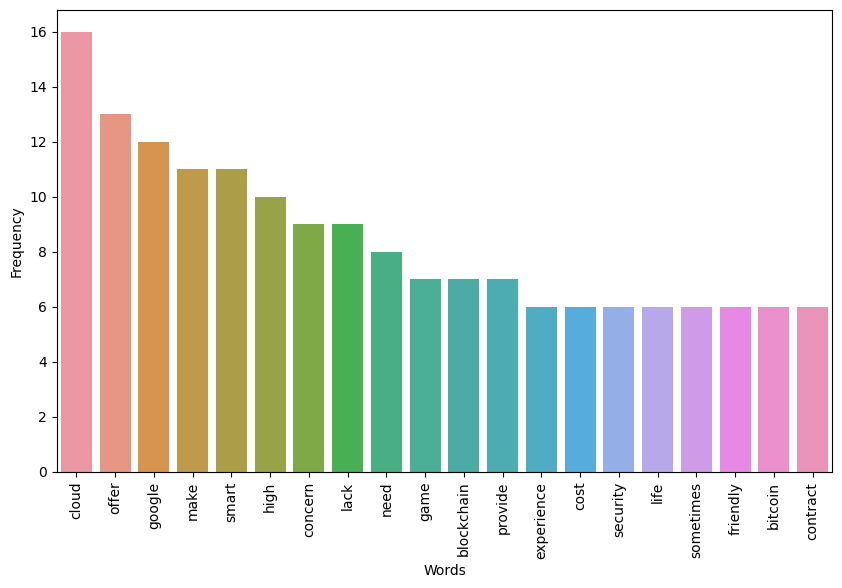

In [30]:
# define figure size
plt.figure(figsize=(10, 6))
# set xlables style verticle
plt.xticks(rotation=90)
# plot unigrams on x axis and there freq on y axis
ax = sns.barplot(x=list(top_words_dict.keys()), y= list(top_words_dict.values()))
# set x and y axis labels
ax.set(xlabel='Words', ylabel='Frequency')

# Sentiment Analysis

- Using textblob library we have assigned sentiments to each instance in our dataset
- Texblob is a statistical technique that works on dictionary based structure
- Each word is evaluated from text data, and if the word is find in negative dictionary the sentence will be assigned negative sentiment vice versa

In [31]:
def getPolarity(text):
    score = TextBlob(text).sentiment.polarity
    if score >= 0:
        return "Positive"
    else:
        return "Negative"
data['sentiment'] = data.text.apply(getPolarity)

- We have filtered the data based on sentiments
- We have plotted wordcloud of tokens in the negative and positive dataset separately to display frequency of each token according to sentiments
- Font size of text in plot depicts Frequency of each token 

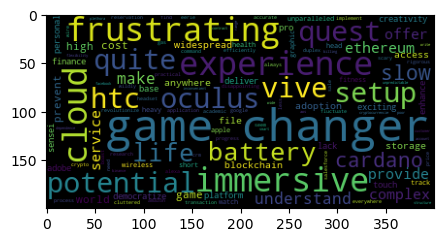

In [32]:
neg_data = data.loc[data['sentiment']=="Negative"]
plt.figure(figsize=(5,8))
# Join the different processed titles together.
long_string = ','.join(list(neg_data['text'].values))
# Create a WordCloud object
wordcloud = WordCloud()
# Generate a word cloud
cloud = wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(cloud)

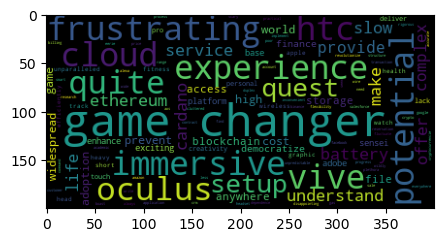

In [33]:
pos_data = data.loc[data['sentiment']=="Positive"]
plt.figure(figsize=(5,8))
# Join the different processed titles together.
long_string = ','.join(list(neg_data['text'].values))
# Create a WordCloud object
wordcloud = WordCloud()
# Generate a word cloud
cloud = wordcloud.generate(long_string)
# Visualize the word cloud
plt.imshow(cloud)

# Interactive Visualization 2
- It creates a grouped bar chart that helps visualize the distribution of sentiments across different topics in the dataset
- Each bar represents the count of a particular sentiment for a specific topic. 
- The bars are grouped by topics, and a dropdown menu is provided that lets you filter the chart to view the sentiment distribution for a selected topic.
- Initially, all bars related to the first topic are visible, and the others are shown in the legend only. 
- When you select a different topic from the dropdown, the visibility of the bars changes to show the sentiment counts for the selected topic. 
- This interactivity enables you to dynamically explore and understand the sentiment spread across various topics, and could provide valuable insights into how sentiments are distributed within and across the topics.

In [34]:

topics = data['topic'].unique()
sentiments = data['sentiment'].unique()

fig = go.Figure()

topic_buttons = []
sentiment_buttons = []

for i, topic in enumerate(topics):
    for j, sentiment in enumerate(sentiments):
        filtered_df = data[(data['topic'] == topic) & (data['sentiment'] == sentiment)]
        fig.add_trace(
            go.Bar(
                x=[sentiment],
                y=[len(filtered_df)],
                name=f'{topic}-{sentiment}',
                visible=True if i == 0 else 'legendonly'
            )
        )

    visible = [False]*len(topics)*len(sentiments)
    visible[i*len(sentiments):(i+1)*len(sentiments)] = [True]*len(sentiments)
    topic_buttons.append(
        dict(
            label=topic,
            method='update',
            args=[{'visible': visible}]
        )
    )

fig.update_layout(
    updatemenus=[
        dict(
            type='dropdown',
            direction='down',
            x=1,
            y=1,
            buttons=topic_buttons
        )
    ],
    barmode='stack'
)

fig.show()


In [35]:
print("Number of positive sentiments:",pos_data.shape[0])
print("Number of negative sentiments:",neg_data.shape[0])

Number of positive sentiments: 105
Number of negative sentiments: 19


## Pie chart of sentiments
- Using matplotlib we have visualized the sentiments frequency in our dataset
- That shows that positive sentiments ahve higher frequency than negative
- Around 85% of data have positive sentiments
- That indicates that dataset is highly imbalanced

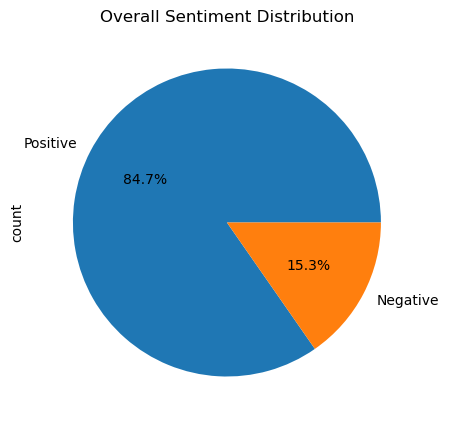

In [36]:
# Count sentiment occurrences
sentiment_counts = data['sentiment'].value_counts()

# Plot the data
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(10, 5))
plt.title('Overall Sentiment Distribution')
plt.show()


# Interactive Visualization 3
- We have plotted a box plot, that is a satndard way of displaying the distribution of data based on a five-number summary: the minimum, the first quartile (25th percentile), the median (50th percentile), the third quartile (75th percentile), and the maximum
- We have plotted sentiments on the x axis that have two unique values positive and negative
- We have plotted topics on the y axis each sentiment box have some part of each topic based on topic distriution along with each sentimnet
- Graph helps us to compare the spread and skewness of topics across different sentiments, and identify any outliers
- We can analyze which topics are relevant to positive sentiment or negative
- It helps to understand the diversity of opinions or the polarisation within each topic
- The graph can be filtered based on sentiments tags on the right
- Can hover, zoom, reset

In [37]:
import plotly.express as px
fig = px.box(data, x="sentiment", y="topic", color='sentiment')
fig.show()

# Part-of-speech tagging
- Part of speech is basically a category assigned to words based on its syntactic functions
- Part of  speech tagging involves breaking down a sentence into its component parts, such as a list of all tokens  made up of tuples, each of which has a form (word, tag). 
- Where word is our actual token and tag is assigned pos
- e.g. (Hello, NN) where hello is token and NN is tag
- each library have its own syntax to present tags notation
- we have used spacy to assign pos tags to our data

In [38]:
def pos_tagging(text):
    doc = nlp(text)
    return [(token.text, token.pos_) for token in doc]

# Apply POS tagging to the 'text' column of the dataframe
data['POS_tags'] = data['text'].apply(pos_tagging)

# Visualize POS tags

# Interactive Visualization 4
- Here we have visualized pos tags frequency in the dataset
- We have plotted pie chart that map pos tags and its frequency in the dataset
- To analyze which pos tags appear most in the data
- User can filter the pos tags by checking or unchecking the particular value on the right
- It will display pos tags frequency based on selected tags
- Plot depicts that almost half of the pos tags are NOUN
- After that Adjective, Proper Noun and Ver ahve higher frequency 
- All other pos tags have very low frequency in the data in comparison to NOUN

In [39]:
import plotly.express as px

# Unpack POS tags
all_tags = [tag for tags in data['POS_tags'] for _, tag in tags]

# Count each POS tag
tag_counts = pd.Series(all_tags).value_counts()

# Create the plot
fig = px.pie(tag_counts, values=tag_counts.values, names=tag_counts.index, title='POS Tag Distribution')
fig.show()


#  Name entity recognition

In [40]:
nlp = spacy.load("en_core_web_sm")
def named_entities(text):
    doc = nlp(text)
    return [ent.label_ for ent in doc.ents]

# Apply NER to the 'text' column of the dataframe
data['NER_tags'] = data['text'].apply(named_entities)

# NER frequency visualization

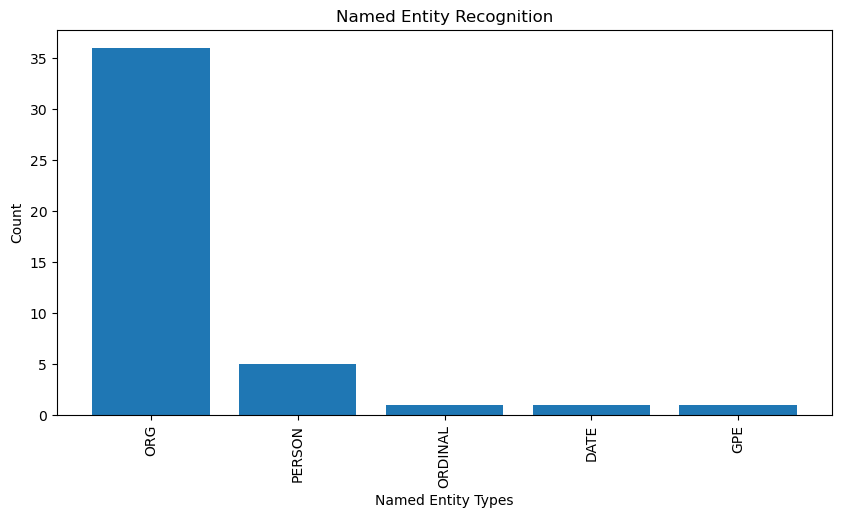

In [41]:
# Count the occurrences of each named entity
ner_counts = Counter([ner for ners in data['NER_tags'] for ner in ners])

# Prepare data for plotting
labels, values = zip(*ner_counts.items())

# Plot the results
plt.figure(figsize=(10,5))
plt.bar(labels, values)
plt.xlabel('Named Entity Types')
plt.ylabel('Count')
plt.title('Named Entity Recognition')
plt.xticks(rotation=90)
plt.show()


# Sequence tagging

In [42]:
def chunk_text(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)

    grammar = """
        NP: {<DT>?<JJ>*<NN>}    # Chunk sequences of DT, JJ, and NN
    """
    chunk_parser = nltk.RegexpParser(grammar)
    tree = chunk_parser.parse(pos_tags)

    return str(tree)

data['parsed_tree'] = data['text'].apply(chunk_text)
data['parsed_tree']

0      (S\n  (NP capability/NN)\n  astounding/VBG\n  ...
1      (S\n  (NP autonomous/JJ car/NN)\n  (NP scare/N...
2      (S\n  (NP algorithm/NN)\n  predict/VBP\n  (NP ...
3      (S\n  (NP concern/NN)\n  replace/VB\n  (NP job...
4      (S\n  (NP ability/NN)\n  analyze/VBP\n  (NP bi...
                             ...                        
119    (S\n  (NP bitcoin/NN)\n  provide/VBP\n  (NP ea...
120    (S\n  (NP ethereum/NN)\n  (NP smart/NN)\n  (NP...
121    (S\n  (NP ripple/NN)\n  (NP fast/JJ internatio...
122    (S\n  (NP litecoin/NN)\n  (NP fast/JJ block/NN...
123    (S\n  (NP chainlink/NN)\n  bring/VBG\n  (NP re...
Name: parsed_tree, Length: 124, dtype: object

# Text summarization

In [43]:
# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the data
vectorizer.fit(data['text'])

# Get the feature names
feature_names = vectorizer.get_feature_names_out()

# Define a function to get the top n tf-idf features for a document
def top_tfidf_features(row, features, top_n=2):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df['feature'].values

# Apply TF-IDF to the data
tfidf_matrix = vectorizer.transform(data['text']).toarray()

# Apply the function to get the top n features
data['text_summary'] = [" ".join(top_tfidf_features(row, feature_names)) for row in tfidf_matrix]
data['text_summary']

0         astounding transform
1                    car trust
2            marketing predict
3             unemployment job
4               ability derive
                ...           
119           volatile digital
120          flexibility write
121         put centralization
122    popularity overshadowed
123                early stage
Name: text_summary, Length: 124, dtype: object

# Text classification

- We have label encode output attribute values positive and negative
- As machine learning model works on numeric data

In [44]:
# takes data (dataframe format) as input.
# encode label values using sklearn label encoder.
# return encoded values and encoder object.
le = preprocessing.LabelEncoder()
le.fit(data['sentiment'])
data['en_label'] = le.transform(data['sentiment'])

In [45]:
# Get input features from data
input_data = data['text']
# Get output labels from data
output_data = data['en_label']

- To train and evaluate the ML models we split data into train and test
- Models will be trained on Train data
- Models will be evaluated on Test data

In [46]:
# Split data into train and test using sklearn train-test split function with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(
    input_data, output_data, test_size=0.20, random_state=2)

## TFIDF Features Extraction
- We created a model that calculates the Term Frequency-Inverse Document Frequency (TF-IDF) of the corpus. 
- TF-IDF is a statistical measure that evaluates how important a word is to a document in a collection or corpus. 
- The importance increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus. 
- This resulting TF-IDF representation of the corpus will be used for ML models as input

In [47]:
# Initialize tfidf vectorizer with maximum 500 features
vectorizer = TfidfVectorizer(max_features=500)

# Fit and transform vectorizer on train data
X_train = vectorizer.fit_transform(X_train)
# Transform vectorizer on test data
X_test = vectorizer.transform(X_test)

print("Train data input features shape: ", X_train.shape)
print("Test data input features shape: ", X_test.shape)

Train data input features shape:  (99, 459)
Test data input features shape:  (25, 459)


In [48]:
print("Vocabulary size: ", len(vectorizer.get_feature_names()))

Vocabulary size:  459


In [49]:
def train_evalute_model(model, model_name, X_train, X_test, y_train, y_test):
    """Return results of model.

    Function to train and predict the test data, and calculate evalution metrices.
    Takes model, train and test data as input.
    Train model on train data.
    Test model performance on test data.
    Evaluate model performance using accuracy, precision, recall, f1 and 
    confusion matrix evaluation metrics. (Use sklearn evaluation metrics)
    """

    start_time = time.time()
    model.fit(X_train.toarray(), y_train)
    y_pred_test = model.predict(X_test.toarray())

    result = {}
    result['Model name'] = model_name

    result['Accuracy'] = accuracy_score(y_test, y_pred_test)
    result['Precision'] = precision_score(y_test, y_pred_test, average='macro')
    result['Recall'] = recall_score(y_test, y_pred_test, average='macro')
    result['F1'] = f1_score(y_test, y_pred_test, average='macro')
    result['Confusion matrix'] = confusion_matrix(y_test, y_pred_test)
    print(model_name, "Model take --- %s seconds ---" % np.round((time.time() - start_time),3))
   

    return result

## Machine Learning Models
### Naïve Bayes
- Naïve Bayes algorithm (NB) is a supervised learning algorithm, depending on Bayes theorem which is used for solving classification problems like text classification with a high-dimensional training dataset. Naïve Bayes algorithm helps us to build a fast machine learning model that can make quick predictions depending on the probability of an object.
### Logistic Regression
- Logistic regression (LR) is a supervised learning algorithm that can be used to solve classification problems. LR is one of the most popular methods that have been used in classification tasks which used logistic function to predict the categorical dependent variable.
### Decision Tree
- Decision tree (DT) classifier  is a supervised machine learning algorithm that can be used to solve classification problems. DT attempts to solve problem using tree representation, where each internal node represent the features of a dataset and have several branches based on decision rules, and each leaf node represents the outcome of those decisions.
### XGBoost
- XGBoost is also called “Extreme Gradient Boosting”. XGBoost executes Machine Learning algorithms under the GBoost framework. It provides a parallel tree boosting to solve a lot of data science problems in a fast and specific way. This method incorporates many weak models to create a powerful predictive learning model. Multiple models can be trained sequentially, gradually, or additively using gradient boosting algorithms
### Random Forest
- A classification model made up of several decision trees is called the random forest. It attempts to produce a statistically independent forest of trees which forecast more precise results rather than any individual discrete tree by using bagging and feature randomness when generating each discrete tree.


In [50]:
results = []
# Logistic Regression
results.append(train_evalute_model(LogisticRegression(
    random_state=0, solver='lbfgs'), 'LR', X_train, X_test, y_train, y_test))
# Random Forest Classifier
results.append(train_evalute_model(RandomForestClassifier(
    n_estimators=100, random_state=0), 'RF', X_train, X_test, y_train, y_test))
# Multinomial NB
results.append(train_evalute_model(MultinomialNB(),
                                   'NB', X_train, X_test, y_train, y_test))
# XGB Classifier
results.append(train_evalute_model(xgb.XGBClassifier(
    objective="binary:logistic", random_state=42), 'XGB', X_train, X_test, y_train, y_test))
# Decision Tree Classifier
results.append(train_evalute_model(DecisionTreeClassifier(
    random_state=0), 'DT', X_train, X_test, y_train, y_test))

LR Model take --- 0.032 seconds ---
RF Model take --- 0.201 seconds ---
NB Model take --- 0.006 seconds ---
XGB Model take --- 0.165 seconds ---
DT Model take --- 0.015 seconds ---


## Machine Learning Model Results 
- As we know that machine learning models performs best on adequate amount of dataset
- But it can been analyzed that all models have fair enough results on our samll dataset
- Gradient boosting algorithm performs having accuracy score of 92%
- That shows that gradient boosting algorithms can perform best even on smal dataset

In [51]:
# Save results as a csv file
results = pd.DataFrame(results)
# Display results
results.iloc[:, :4]

Model name  Accuracy  Precision    Recall
0         LR      0.88   0.440000  0.500000
1         RF      0.88   0.440000  0.500000
2         NB      0.88   0.440000  0.500000
3        XGB      0.92   0.958333  0.666667
4         DT      0.88   0.706522  0.643939

## Confusion matrix
- We have plotted confusion matrix of ML model results 
- Confusion matrix helps to identify each class true and flase predictions

	    LR Model confusion matrix plot
	+====================================+


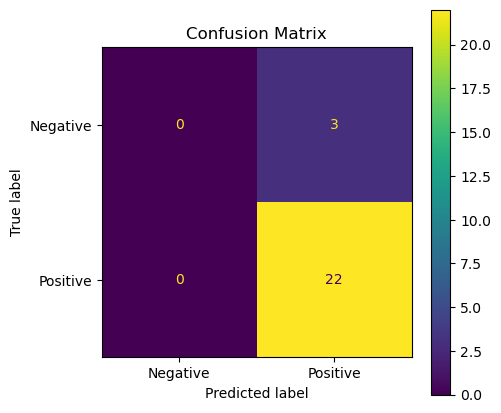

	    RF Model confusion matrix plot
	+====================================+


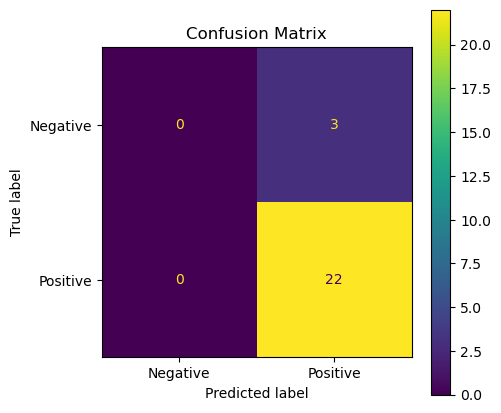

	    NB Model confusion matrix plot
	+====================================+


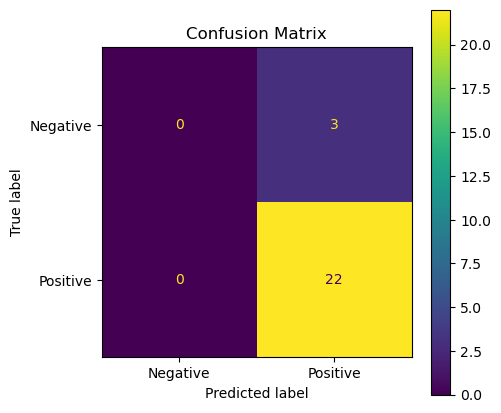

	    XGB Model confusion matrix plot
	+====================================+


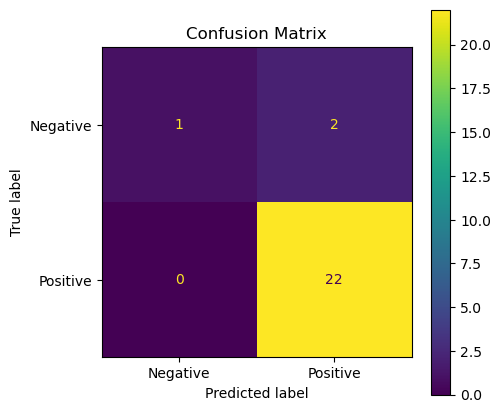

	    DT Model confusion matrix plot
	+====================================+


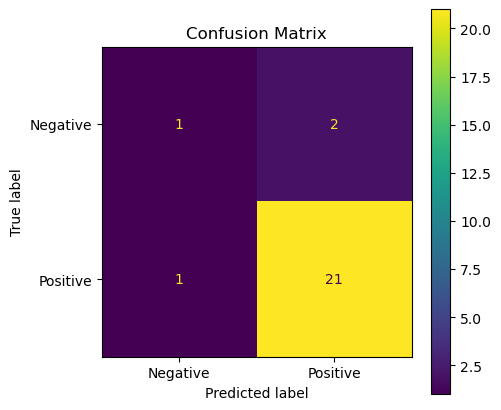

In [52]:
def plot_cm_matrix(data):
    """Generate confusion matrix of all models.
    """
    for i in cm_results.iterrows():
        print("\t   ", i[1][1], "Model confusion matrix plot")
        print("\t+====================================+")
        disp = ConfusionMatrixDisplay(i[1][0], display_labels=le.classes_)
        fig, ax = plt.subplots(figsize=(5, 5))
        disp.plot(ax=ax)
        plt.title("Confusion Matrix")
        plt.show()


cm_results = results[['Confusion matrix', 'Model name']]
plot_cm_matrix(cm_results)

# Clustering
- Here we have built clustering model k-means to cluster data into subgroups
- Clustering is done when we have unlabel data
- K-means is popular algorithm for clustering
- It starts by randomly assigning 'k' centroids, where 'k' denotes the preset number of clusters. Each data point is given to the cluster that the closest centroid best represents.
- It iterates and improve clusters
- Based on number of topics of our complete data we have assigned 5 clusters
- We have extracted bow features using countvectorizer of sklearn
- We can see that k-means model was not able to group relevant data togeather
- It assigns the most weight to group 2 only

In [53]:
n_grams = CountVectorizer(max_df=0.95, min_df=2, ngram_range = (1,2))
n_grams_vec = n_grams.fit_transform(data['text'])
n_grams_feature_names = n_grams.get_feature_names()

In [54]:
def cluster_model(data, features, number_of_clusters):
    km = KMeans(n_clusters=number_of_clusters)
    km.fit(features)
    new_data = pd.DataFrame(data['text'])
    new_data['label'] = km.fit_predict(features)
    
    value_centroids = np.sort(km.cluster_centers_)[:, ::-1]
    index_centroids = km.cluster_centers_.argsort()[:, ::-1]
    
    return new_data, value_centroids, index_centroids

In [55]:
number_of_clusters = 5
new_data, value_centroids, index_centroids = cluster_model(data, n_grams_vec, number_of_clusters)

In [56]:
np.unique(new_data['label'], return_counts=True)

(array([0, 1, 2, 3, 4]), array([111,   2,   5,   4,   2], dtype=int64))

## Visualization of clusters


			Cluster 1
+=========================================================+


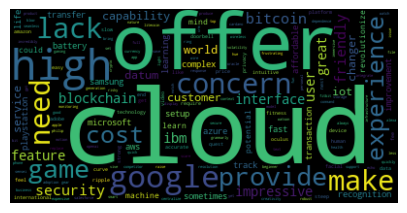


			Cluster 2
+=========================================================+


<Figure size 640x480 with 0 Axes>

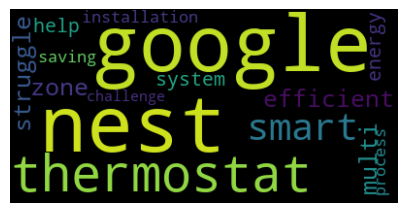


			Cluster 3
+=========================================================+


<Figure size 640x480 with 0 Axes>

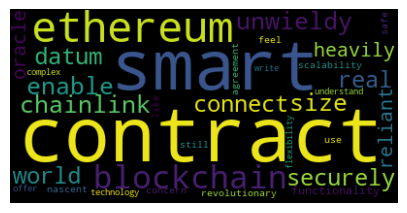


			Cluster 4
+=========================================================+


<Figure size 640x480 with 0 Axes>

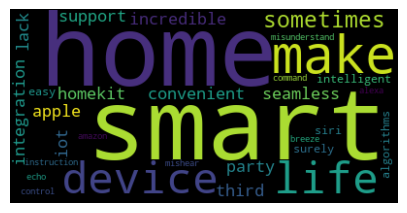


			Cluster 5
+=========================================================+


<Figure size 640x480 with 0 Axes>

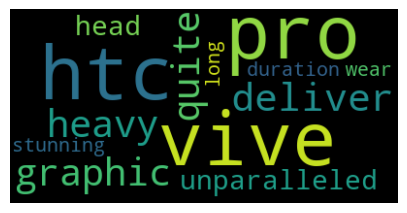

<Figure size 640x480 with 0 Axes>

In [57]:
words_num = None
for i in range(number_of_clusters):
    print("\n\t\t\tCluster",i+1)
    print("+=========================================================+")
    copy = new_data.loc[new_data['label'] == i]
    
    results_total = Counter()
    copy['text'].str.split().apply(results_total.update)
   
    plot_words = dict(sorted(results_total.items(), key=lambda item: item[1],reverse = True)[:words_num])

    # Generate a word cloud image
    wordcloud = WordCloud(background_color="black").generate_from_frequencies(plot_words)

    # define plotting figure size
    plt.figure(figsize=(5,8))
    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    # dispaly figure size
    plt.clf()


#  Similarity analysis
- To find similarity of multiple documents or instances we have used sklearn cosine similarity matrix 
- At first we have extracted features using tfidf vectorizer
- We pass those features to cosine similarity matrix that assigns higher scores to documents that have more similar text

In [58]:
from sklearn.metrics.pairwise import cosine_similarity

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer to the data and transform the 'text' column
tfidf_vectors = vectorizer.fit_transform(data['conversation'])

# Convert the tfidf_vectors to an array and store in the DataFrame
data['tfidf_vector'] = tfidf_vectors.toarray().tolist()

# Calculate the cosine similarity
csim = cosine_similarity(tfidf_vectors)

# Print the cosine similarity matrix
similarity_data = pd.DataFrame(csim)
similarity_data.columns = ["doc_"+str(i) for i in range(similarity_data.shape[0])]
similarity_data.to_excel("cs.xlsx")

# Noun phrase extraction
- A noun phrase, used in Natural Language Processing (NLP), is a collection of words that collectively serve as a noun in a documnet.
- It frequently contains a noun as well as terms that enhance the noun.  
- Extracting Noun phrase from a text is frequently a crucial first step in NLP text analysis as these phrases can include important data
- It can be utilized to comprehend the primary topics in a document and how these interact with each other
- We have used spacy to extract noun phrases from data
- We can get a clear sense of the main topics or entities within each text, which can provide useful context and help to analyze data

In [59]:
nlp = spacy.load("en_core_web_sm")
data['noun_phrases'] = data['text'].apply(lambda text: list(nlp(text).noun_chunks))
data['noun_phrases'] 

0                 [(capability, astounding), (industry)]
1      [(autonomous, car, scare, trust, machine, drive)]
2       [(algorithm), (customer, behavior), (marketing)]
3                            [(concern), (unemployment)]
4      [(ability), (big, datum, derive, insight, mind...
                             ...                        
119    [(bitcoin), (easy, entry, world, digital, curr...
120    [(ethereum, smart, contract), (flexibility, co...
121    [(ripple, fast, international, transfer, comme...
122    [(fast, block, generation, impressive, oversha...
123    [(chainlink), (real, world, datum, blockchain,...
Name: noun_phrases, Length: 124, dtype: object

#  Dependency parsing
- Dependency parsing is a technique used in natural language processing to examine the grammatical structure of a phrase by considering the relationships connecting its individual words
- In essence, it aids in our comprehension of the relationships between the words in a sentence
- It's similar to drawing a "map" of our statement to indicate which words are directly influencing which ones
- These connections are what dependency parsing looks for when applied to a text
- It will help us to identify more important words for example VERBS, NOUNs and how these are connected and there flow
- We have performed dependency parsing using spacy

In [60]:
def parse_dependencies(text):
    doc = nlp(text)
    return [(token.text, token.dep_, token.head.text) for token in doc]

data['parsed_dependencies'] = data['text'].apply(parse_dependencies)
data['parsed_dependencies']

0      [(capability, compound, astounding), (astoundi...
1      [(autonomous, amod, drive), (car, compound, sc...
2      [(algorithm, nsubj, predict), (predict, ROOT, ...
3      [(concern, nsubj, replace), (replace, compound...
4      [(ability, nsubj, analyze), (analyze, ROOT, an...
                             ...                        
119    [(bitcoin, nsubj, provide), (provide, ROOT, pr...
120    [(ethereum, nmod, contract), (smart, amod, con...
121    [(ripple, amod, aspect), (fast, amod, aspect),...
122    [(litecoin, ROOT, litecoin), (fast, amod, bloc...
123    [(chainlink, nsubj, bring), (bring, ROOT, brin...
Name: parsed_dependencies, Length: 124, dtype: object

## Visualize dependencies
- Here we have plotted dependency parsing results using displacy feature of spacy library
- It plots each document tags dependency in very interactive way show the connectivity of all tags and flow
- On curve it shows the relation
- Using arrows it shows direction
- It also provides a slider so we can select any document that we want to display

In [61]:
from spacy import displacy
from ipywidgets import interact

nlp = spacy.load("en_core_web_sm")
def plot_dependency(index):
    text = data['text'].iloc[index]
    doc = nlp(text)
    return displacy.render(doc, style="dep", jupyter=True)

# use interact from ipywidgets to create a slider for dataframe index
interact(plot_dependency, index=(0, len(data)-1))

interactive(children=(IntSlider(value=61, description='index', max=123), Output()), _dom_classes=('widget-inte…

<function __main__.plot_dependency(index)>

In [62]:
#pip install jupyter_dash

# Interactive Visualization 5
- We have plotted heatmap of our text similarity data matrix
- The interactive visualization provides an in-depth understanding of the document similarity within a collection of documents. - Each cell corresponds to a pair of documents from the collection
- Color of each cell indicates the value of similarity of both connected documents on that point as from the bar on right it can be seen that darker the color more similar are documents and lighter the color less similar are documents
- Bar on the right show the frequency based on color
- A slider is provided to allow the user to select the number of documents they want to consider for the analysis, ranging from one to 124. This functionality enables a dynamic update of the visualization based on user input, making it a flexible tool for examining subsets of the document collection.
- When you move the slider you can display higher or lower number of documents 
- It helps to display the similarity of complete data as well as subset of data

In [63]:
import dash
from dash import dcc, html
import plotly.graph_objects as go
import pandas as pd
import numpy as np

similarity_data = np.random.rand(124, 124)

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Slider(
        id='num-docs-slider',
        min=1,
        max=124,
        step=1,
        value=124,
    ),
    dcc.Graph(id='heatmap-graph')
])

@app.callback(
    dash.dependencies.Output('heatmap-graph', 'figure'),
    [dash.dependencies.Input('num-docs-slider', 'value')])
def update_graph(num_docs):
    figure = go.Figure(data=go.Heatmap(
        z=similarity_data[:num_docs, :num_docs],
        x=list(range(1, num_docs + 1)),
        y=list(range(1, num_docs + 1)),
        text=np.around(similarity_data[:num_docs, :num_docs], decimals=2),  # show values in each cell
        hoverinfo='text',  # show text when hovering
        hoverongaps=False))
    figure.update_layout(
        title=f'Heatmap of first {num_docs} docs',
        xaxis_nticks=40,
        yaxis_nticks=40,
        autosize=False,
        width=800,
        height=800,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ))
    return figure


if __name__ == '__main__':
    app.run_server(debug=True)
